# Data preparation for CWGAN

## PV

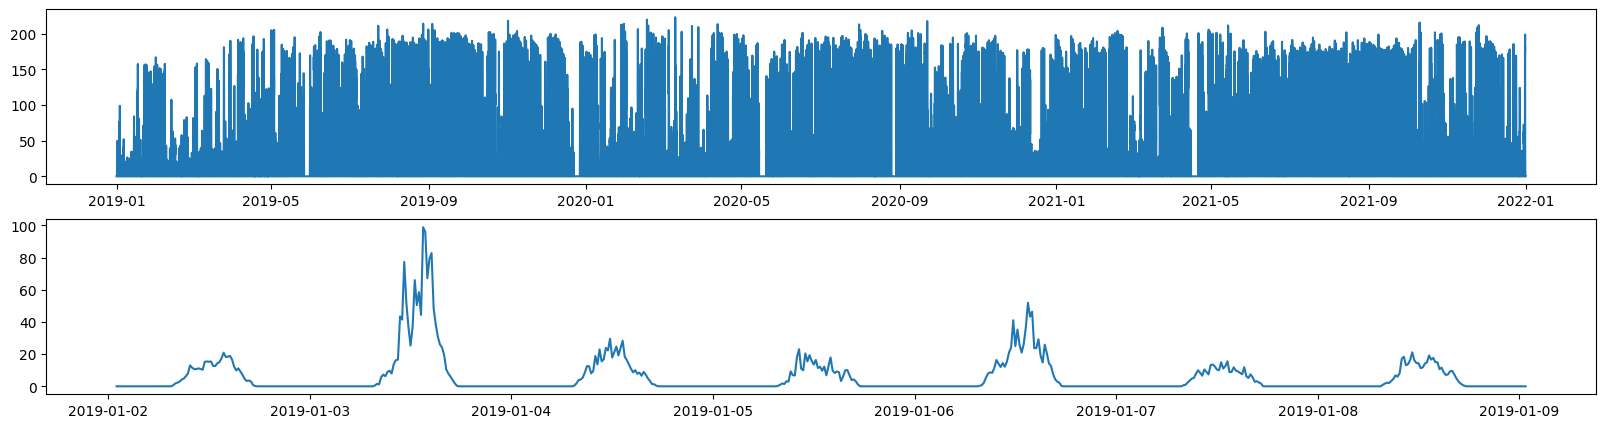

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pth = "data/PV_jz.csv"
pv = pd.read_csv(pth)
pv["ds"] = pd.to_datetime(pv["ds"])
fig, ax = plt.subplots(2, figsize=[20,5])
ax[0].plot(pv["ds"], pv["value"])
ax[1].plot(pv["ds"][100:100+96*7], pv["value"][100:100+96*7])

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from utils import scale


def split_timestamp(pth) -> pd.DataFrame:
    df = pd.read_csv(pth)

    df_time = df["ds"].str.split(' ', expand=True)
    df_date = df_time[0].str.split('/', expand=True)
    df_date.columns = ["year", "month", "date"]
    df_hour = df_time[1].str.split(':', expand=True)
    df_hour.columns = ["hour", "minute"]

    df_all_time = pd.concat([df_date, df_hour, df[["value"]]], axis=1)
    df_all_time = df_all_time.astype("float")

    return df_all_time


pth = "data/PV_jz.csv"
df = split_timestamp(pth)

# drop useless feature
df.drop(["year", "value", "minute", "hour"], axis=1, inplace=True)
pv_reshape = pd.read_csv(pth).values[:, -1].reshape(-1, 96)
scaler = float(pv_reshape.max())
pv_reshape = pv_reshape / scaler

print(f"max value: {scaler}")
df = df.values

# concat each day data
results = np.zeros([pv_reshape.shape[0], pv_reshape.shape[1] + df.shape[1]])
start = 0
for i in range(len(pv_reshape)):

    results[i, :] = np.concatenate([pv_reshape[i, :], df[start, :]], axis=0)
    start = start + 96
print(results)
# split, scale and save
pv_train, pv_test = train_test_split(results, test_size=0.2, shuffle=False)
scale(pv_train, 0, pv_test, scaler=scaler, name="pv")

max value: 222.967
[[ 0.  0.  0. ...  0.  1.  1.]
 [ 0.  0.  0. ...  0.  1.  2.]
 [ 0.  0.  0. ...  0.  1.  3.]
 ...
 [ 0.  0.  0. ...  0. 12. 29.]
 [ 0.  0.  0. ...  0. 12. 30.]
 [ 0.  0.  0. ...  0. 12. 31.]]


## Wind

expected length:	 105216
wind length:	 105216


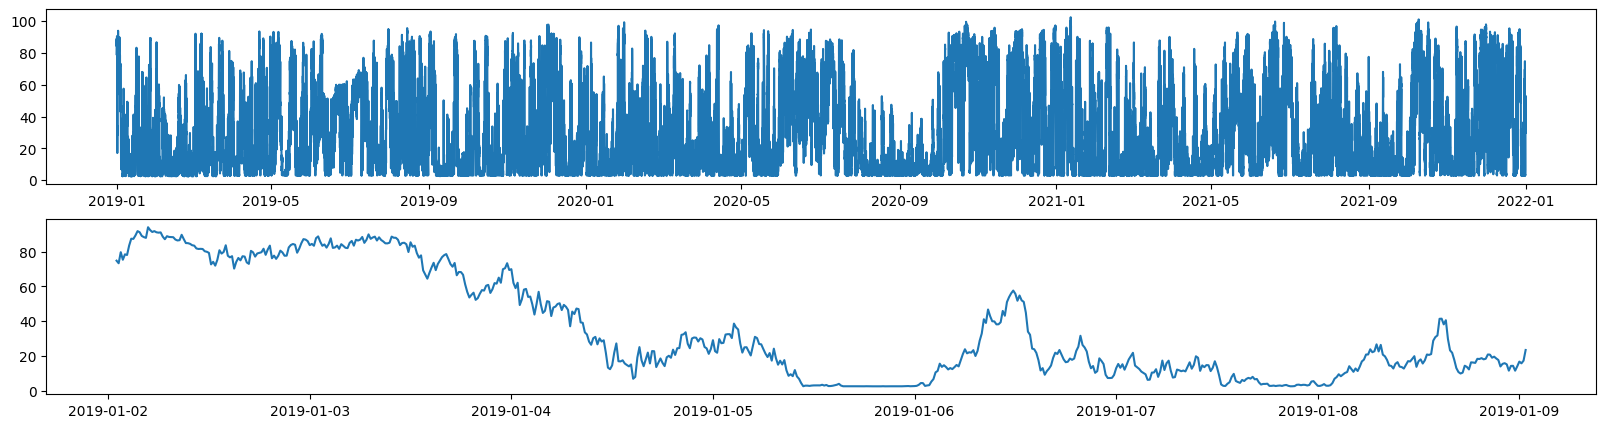

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

time_col = pd.DataFrame(pd.date_range(start="1/1/2019 00:00:00",
                                      end="12/31/2021 23:45:00",
                                      freq="15min"),
                        columns=["ds"])
wind = pd.read_csv("data/wind_sps.csv")
wind["ds"] = pd.to_datetime(wind["ds"])
print("expected length:\t", len(time_col))
print("wind length:\t", len(wind))
wind = pd.merge(time_col, wind, how="outer")
wind = wind.ffill()
wind["value"] = wind["value"]+1
# wind.to_csv("data/wind_sps.csv", index=False)
fig, ax = plt.subplots(2, figsize=[20,5])
ax[0].plot(wind["ds"], wind["value"])
ax[1].plot(wind["ds"][100:100+96*7], wind["value"][100:100+96*7])

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from utils import scale


def split_timestamp(pth) -> pd.DataFrame:
    df = pd.read_csv(pth)
    df_time = df["ds"].str.split(' ', expand=True)
    df_date = df_time[0].str.split('-', expand=True)
    df_date.columns = ["year", "month", "date"]
    df_hour = df_time[1].str.split(':', expand=True)
    df_hour.columns = ["hour", "minute", "second"]
    df_all_time = pd.concat([df_date, df_hour, df[["value"]]], axis=1)
    df_all_time = df_all_time.astype("float")
    return df_all_time


pth = "data/wind_sps.csv"
df = split_timestamp(pth)

# drop useless feature
df.drop(["year", "value", "minute", "hour", "second"], axis=1, inplace=True)
wind_reshape = pd.read_csv(pth).values[:, -1].reshape(-1, 96)
scaler = float(wind_reshape.max())
wind_reshape = wind_reshape / scaler
print(f"max value: {scaler}")
df = df.values

# concat each day data
results = np.zeros(
    [wind_reshape.shape[0], wind_reshape.shape[1] + df.shape[1]])
start = 0
for i in range(len(wind_reshape)):
    results[i, :] = np.concatenate([wind_reshape[i, :], df[start, :]], axis=0)
    start = start + 96
print(f"max value: {results}")

# split, scale and save
pv_train, pv_test = train_test_split(results, test_size=0.2, shuffle=False)
scale(pv_train, 0, pv_test, scaler=scaler, name="wind")


max value: 101.5349
max value: [[7.71306221e-01 7.84417969e-01 8.05775157e-01 ... 6.17433021e-01
  1.00000000e+00 1.00000000e+00]
 [6.83677238e-01 6.83044943e-01 7.70839386e-01 ... 8.37714914e-01
  1.00000000e+00 2.00000000e+00]
 [8.14983813e-01 8.21882919e-01 8.11437250e-01 ... 6.74029324e-01
  1.00000000e+00 3.00000000e+00]
 ...
 [2.80534082e-02 5.77673293e-02 4.80918384e-02 ... 1.46605748e-01
  1.20000000e+01 2.90000000e+01]
 [1.73488131e-01 1.67276473e-01 2.33877219e-01 ... 2.95915986e-01
  1.20000000e+01 3.00000000e+01]
 [2.39649618e-01 2.82942121e-01 2.69363539e-01 ... 3.76783746e-01
  1.20000000e+01 3.10000000e+01]]


# Test Trained GAN

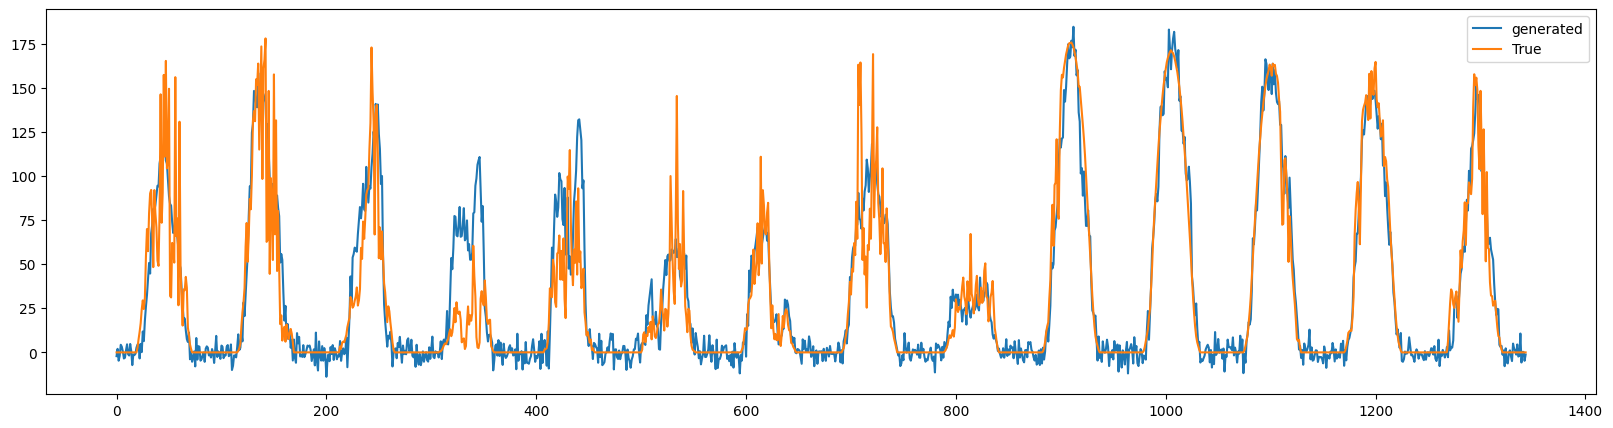

In [45]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

power_type = "pv"
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
scaler = mydata["scaler"]
test_ds = mydata["test_ds"]

generator = torch.load(f"loggings/{power_type}_generator.pth")
generator.eval()

final_results = []
for i in range(len(test_ds)):
    select = i

    # select = 50
    target = test_ds[select][:-2]
    cond = test_ds[select][-2:].reshape(1, -1)
    # target = torch.from_numpy(target).float().cuda()
    cond = torch.from_numpy(cond).float().cuda()

    num = 1000
    dist = 99999999
    idx = 0
    record = []
    for i in range(num):
        z = torch.normal(0, 1, [1, 96]).cuda()

        # print(z)
        # break
        y_hat = generator(z, cond)
        y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
        y_hat = y_hat.astype(float)
        if np.linalg.norm(y_hat - target) < dist:
            dist = np.linalg.norm(y_hat - target)
            idx = i
        record.append(y_hat)
    best_fit = record[idx]
    final_results.append(best_fit)
final_results = np.concatenate(final_results, axis=0) * scaler

start = 100
plot_len = 96 * 14
end = start + plot_len
fig, ax = plt.subplots(figsize=[20, 5])
ax.plot(range(plot_len), final_results[start:end], label="generated")
ax.plot(range(plot_len), test_ds[:, :-2].flatten()[start:end] * scaler, label="True")
ax.legend()
# print(len(best_fit))
# plt.plot(range(96), target, label="True")
# plt.plot(range(96), best_fit, label="generated")
# plt.legend()
# plt.savefig("loggings/pv_gen.png")


# Evaluation

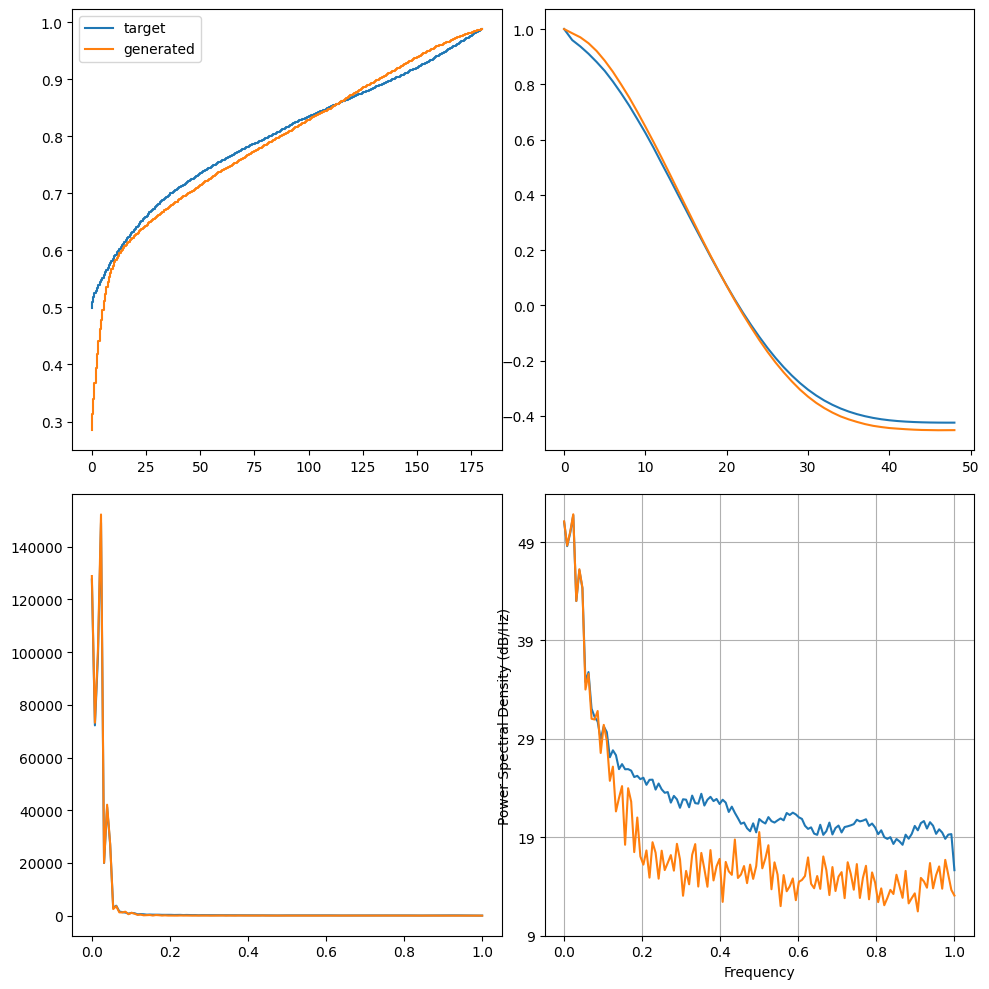

In [46]:
from utils import autocor, cdf, psd, ws_dist, cor_dist, dtw_dist
import numpy as np

target = test_ds[:, :-2].flatten() * scaler
best_fit = final_results

fig, ax = plt.subplots(2, 2, figsize=[10, 10])
fn_target = cdf(target)
fn_fit = cdf(best_fit)
x = np.linspace(0, 180, 300)
ax[0][0].step(x, fn_target(x), label="target")
ax[0][0].step(x, fn_fit(x), label="generated")

atc_tgt = autocor(target, lags=48, plot=False)
atc_best = autocor(best_fit, lags=48, plot=False)
ax[0][1].plot(range(len(atc_tgt)), atc_tgt, label="target")
ax[0][1].plot(range(len(atc_tgt)), atc_best, label="generated")
atc_tgt, freq_tgt = psd(target)
atc_best, freq_best = psd(best_fit)
ax[1][0].plot(freq_tgt, atc_tgt, label="target")
ax[1][0].plot(freq_best, atc_best, label="generated")

ax[0][0].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
